# Analysis for Group Project

### A single dataset is used for all the crop prices 

this dataset displays a time series of prices for different Canadian agricultural products over time.

[Farm product prices, crops and livestock](https://open.canada.ca/data/en/dataset/d5614095-e77a-4cb4-a5e6-9f8bff067c9f)


In [2]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm


# here is a util we'll use to plot graphs of prices
def _plot_time_series_from_df(df, x, y, z, product_name):
    sns.lineplot(data=df, x=x, y=y, hue=z)
    plt.title(f"Time Series of Prices for {product_name}")
    plt.xlabel("Date")
    plt.ylabel(df["UOM"].iloc[0])


In [3]:
# CSV was downloaded and added to the git repo
# Read in the prices CSV
prices_df = pd.read_csv("./data/32100077.csv")
prices_df.head()

,REF_DATE,GEO,DGUID,Farm products,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1980-01,Manitoba,2016A000246,"Canadian Wheat Board, wheat including payments",Dollars per metric tonne,117,units,0,v31212166,7.4,170.49,NaN,NaN,t,2
1,1980-01,Manitoba,2016A000246,"Canadian Wheat Board, wheat excluding payments",Dollars per metric tonne,117,units,0,v31212167,7.5,133.74,NaN,NaN,t,2
2,1980-01,Manitoba,2016A000246,"Canadian Wheat Board, durum including payments",Dollars per metric tonne,117,units,0,v31212168,7.6,178.79,NaN,NaN,t,2
3,1980-01,Manitoba,2016A000246,"Canadian Wheat Board, durum excluding payments",Dollars per metric tonne,117,units,0,v31212169,7.7,142.90,NaN,NaN,t,2
4,1980-01,Saskatchewan,2016A000247,"Canadian Wheat Board, wheat including payments",Dollars per metric tonne,117,units,0,v31212202,8.4,175.79,NaN,NaN,t,2


In [4]:
# DATA PREP

# if you look at the DF, there is a date column in the format of YYYY-MM
## let's turn this into a proper datetime object 
prices_df["REF_DATE"] = pd.to_datetime(prices_df["REF_DATE"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m")))
# let's also add an integer column for Year
## this column will be useful for grouping in our analysis
prices_df["YEAR"] = prices_df["REF_DATE"].apply(lambda x: x.year)
## convert UOM to category data type
prices_df["UOM"] = prices_df["UOM"].astype("category")
## convert SCALAR_FACTOR to category data type
prices_df["SCALAR_FACTOR"] = prices_df["SCALAR_FACTOR"].astype("category")
prices_df.head()


,REF_DATE,GEO,DGUID,Farm products,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,YEAR
0,1980-01-01,Manitoba,2016A000246,"Canadian Wheat Board, wheat including payments",Dollars per metric tonne,117,units,0,v31212166,7.4,170.49,NaN,NaN,t,2,1980
1,1980-01-01,Manitoba,2016A000246,"Canadian Wheat Board, wheat excluding payments",Dollars per metric tonne,117,units,0,v31212167,7.5,133.74,NaN,NaN,t,2,1980
2,1980-01-01,Manitoba,2016A000246,"Canadian Wheat Board, durum including payments",Dollars per metric tonne,117,units,0,v31212168,7.6,178.79,NaN,NaN,t,2,1980
3,1980-01-01,Manitoba,2016A000246,"Canadian Wheat Board, durum excluding payments",Dollars per metric tonne,117,units,0,v31212169,7.7,142.90,NaN,NaN,t,2,1980
4,1980-01-01,Saskatchewan,2016A000247,"Canadian Wheat Board, wheat including payments",Dollars per metric tonne,117,units,0,v31212202,8.4,175.79,NaN,NaN,t,2,1980


In [5]:
# let's look at the shape of the data frames
print(prices_df.shape)

(109951, 16)


In [6]:
# Just so that we have a comprehensive list of the different products in this dataset, let's print out a unique lit of the `Farm products` column 

products = pd.Series(prices_df["Farm products"].sort_values().unique(), name="products")
products

0                                      Barley [1151141]
1                    Barley for animal feed [115114111]
2     Barley for malt and other human consumption [1...
3                         Calves for feeding [11111122]
4                      Calves for slaughter [111111211]
5       Canadian Wheat Board, barley excluding payments
6       Canadian Wheat Board, barley including payments
7        Canadian Wheat Board, durum excluding payments
8        Canadian Wheat Board, durum including payments
9     Canadian Wheat Board, selected barley excludin...
10    Canadian Wheat Board, selected barley includin...
11       Canadian Wheat Board, wheat excluding payments
12       Canadian Wheat Board, wheat including payments
13                              Canary seeds [11511555]
14                 Canola (including rapeseed) [113111]
15                        Cattle for feeding [11111112]
16                      Cattle for slaughter [11111111]
17                         Chickens for meat [11

# Part 3: Wheat


In [7]:
# Prices

# DATA PREP

# define a `products` variable that will be used to select the rows of interest
product = "Wheat (except durum wheat) [1121111]"

# create a boolean mask that will select chickens for meat and rows where the `VALUE` column is not null 
mask = (prices_df["Farm products"] == product) & (prices_df["VALUE"].notnull())
wheat_prices_df = prices_df[mask]
wheat_prices_df.head()

,REF_DATE,GEO,DGUID,Farm products,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,YEAR
15534,1992-01-01,Prince Edward Island,2016A000211,Wheat (except durum wheat) [1121111],Dollars per metric tonne,117,units,0,v31212059,2.3,144.57,NaN,NaN,NaN,2,1992
15550,1992-01-01,Nova Scotia,2016A000212,Wheat (except durum wheat) [1121111],Dollars per metric tonne,117,units,0,v31212078,3.3,152.13,NaN,NaN,NaN,2,1992
15566,1992-01-01,New Brunswick,2016A000213,Wheat (except durum wheat) [1121111],Dollars per metric tonne,117,units,0,v31212097,4.3,129.46,NaN,NaN,NaN,2,1992
15582,1992-01-01,Quebec,2016A000224,Wheat (except durum wheat) [1121111],Dollars per metric tonne,117,units,0,v31212116,5.3,128.58,NaN,NaN,NaN,2,1992
15753,1992-02-01,Prince Edward Island,2016A000211,Wheat (except durum wheat) [1121111],Dollars per metric tonne,117,units,0,v31212059,2.3,146.40,NaN,NaN,NaN,2,1992


In [8]:
# we need to make sure we are only dealing with a single category for UoM and Scale
## sometimes these datasets will have the same data in a subsequent row for a different scale. e.g., `Dollars per kg` vs. `dollars per pound`.
assert wheat_prices_df["Farm products"].unique().__len__() == 1
assert wheat_prices_df["UOM"].unique().__len__() == 1
assert wheat_prices_df["SCALAR_FACTOR"].unique().__len__() == 1

# if there is no exception raised, we are good to go!  

When we look at the historical prices, Newfoundland looks very different from the other provinces. It is clear that NL is distinct from the rest of the country which is comparatively in lock step. 

That being considered, it would make sense to exclude this province from our analysis.

Furthermore, in order to work with the data, it will be easier to have all the price data aggregated into a single response. 

The graphs below show the three states of the data:

1. The raw price data from all the provinces
2. The raw price data from all the provinces except for NL which was excluded
3. An aggregated price curve - the annual mean for all provinces, excluding NL


<Axes: title={'center': 'Aggregated Price of Wheat in Canada (1992-2023)'}, xlabel='Date', ylabel='Dollars per metric tonne'>

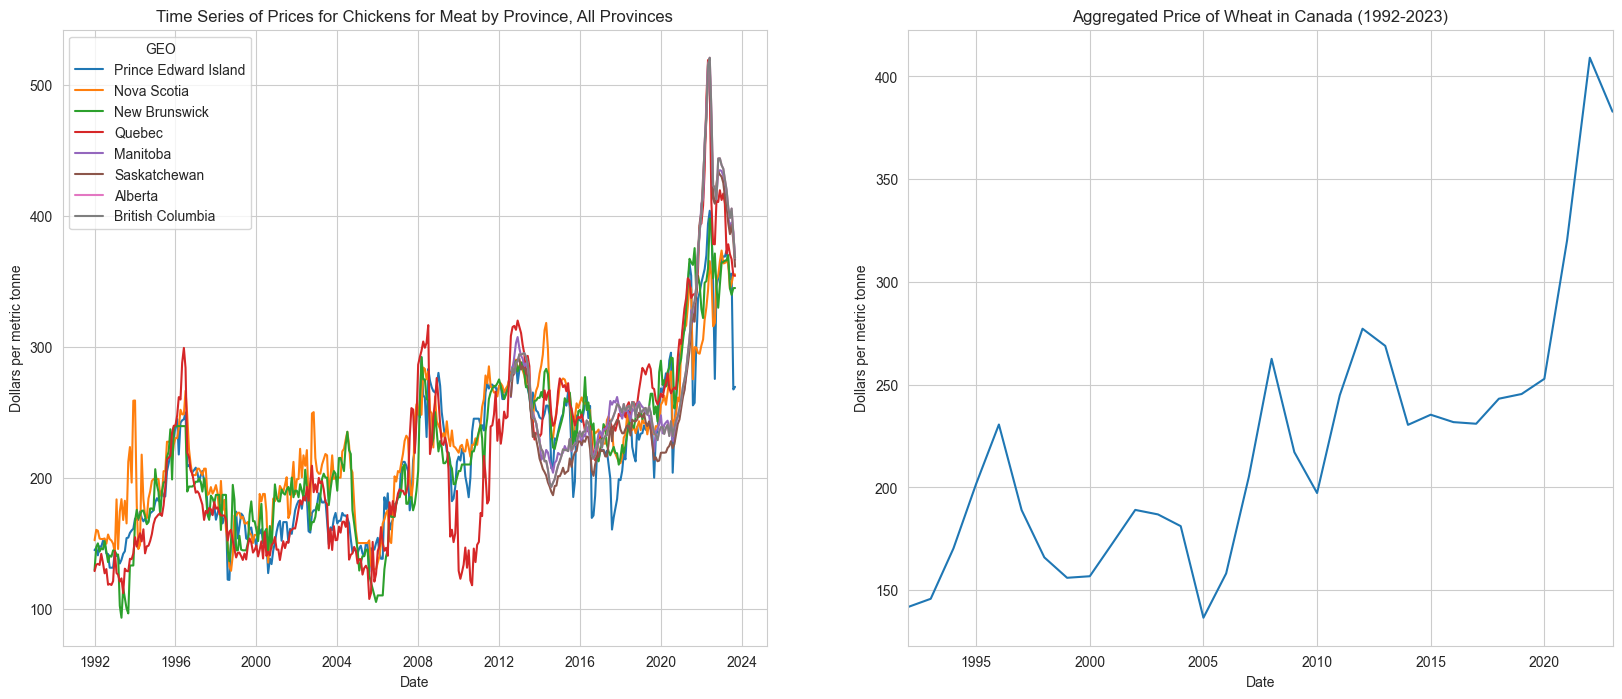

In [9]:
# define the fig size
plt.figure(figsize=(20, 8))

# plot with all provinces
plt.subplot(1, 2, 1)
_plot_time_series_from_df(wheat_prices_df, "REF_DATE", "VALUE", "GEO", "Chickens for Meat by Province, All Provinces")

# plot with all provinces, combined into a single variable
plt.subplot(1, 2, 2)
wheat_prices_df.groupby("YEAR")["VALUE"].mean()

# convert to time series - this will be used later on for the final analysis
ser_wheat_prices = pd.Series(
    data=wheat_prices_df.groupby("YEAR")["VALUE"].mean(numeric_only=True).values,
    index=wheat_prices_df.groupby("YEAR").mean(numeric_only=True).index.to_series().apply(lambda x: dt.datetime.strptime(str(x), "%Y")),
    name="prices"
)

# labels for plot
labels = {
    "title": f"Aggregated Price of Wheat in Canada ({ser_wheat_prices.index.min().year}-{ser_wheat_prices.index.max().year})",
    "xlabel": "Date",
    "ylabel": "Dollars per metric tonne",
}
ser_wheat_prices.plot(**labels)



Now we need some production data. Let's use this dataset: 
[Farm supply and disposition of grains](https://open.canada.ca/data/en/dataset/dd8ffdfb-d9fb-4f16-be28-50632a64d95c)

In [10]:

# from https://open.canada.ca/data/en/dataset/dd8ffdfb-d9fb-4f16-be28-50632a64d95c

# CSV was downloaded and added to the git repo
# This will be the response variable
production_df = pd.read_csv("./data/32100015.csv")

# let's take a look
print(production_df.shape)
production_df.head()


(55712, 16)


,REF_DATE,GEO,DGUID,Type of crop,Farm supply and disposition of grains,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2001-12,Canada,2016A000011124,All wheat,Total supplies,Metric tonnes,214,thousands,3,v73866772,1.1.1,23305.2,NaN,NaN,NaN,1
1,2001-12,Canada,2016A000011124,All wheat,Beginning stocks,Metric tonnes,214,thousands,3,v73866773,1.1.2,2675.0,NaN,NaN,NaN,1
2,2001-12,Canada,2016A000011124,All wheat,Production,Metric tonnes,214,thousands,3,v73866774,1.1.3,20630.2,NaN,NaN,NaN,1
3,2001-12,Canada,2016A000011124,All wheat,Total disposition,Metric tonnes,214,thousands,3,v73866775,1.1.4,23305.2,NaN,NaN,NaN,1
4,2001-12,Canada,2016A000011124,All wheat,Deliveries,Metric tonnes,214,thousands,3,v73866776,1.1.5,9092.0,NaN,NaN,NaN,1


In [11]:
# DATA PREP

# convert the year to a datetime obj
production_df["REF_DATE"] = pd.to_datetime(production_df["REF_DATE"].apply(lambda x: dt.datetime.strptime(str(x), "%Y-%m")))
# let's add two columns; one for month and the other for year
production_df["YEAR"] = production_df["REF_DATE"].apply(lambda x: x.year)
production_df["MONTH"] = production_df["REF_DATE"].apply(lambda x: x.month)
production_df




,REF_DATE,GEO,DGUID,Type of crop,Farm supply and disposition of grains,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,YEAR,MONTH
0,2001-12-01,Canada,2016A000011124,All wheat,Total supplies,Metric tonnes,214,thousands,3,v73866772,1.1.1,23305.2,NaN,NaN,NaN,1,2001,12
1,2001-12-01,Canada,2016A000011124,All wheat,Beginning stocks,Metric tonnes,214,thousands,3,v73866773,1.1.2,2675.0,NaN,NaN,NaN,1,2001,12
2,2001-12-01,Canada,2016A000011124,All wheat,Production,Metric tonnes,214,thousands,3,v73866774,1.1.3,20630.2,NaN,NaN,NaN,1,2001,12
3,2001-12-01,Canada,2016A000011124,All wheat,Total disposition,Metric tonnes,214,thousands,3,v73866775,1.1.4,23305.2,NaN,NaN,NaN,1,2001,12
4,2001-12-01,Canada,2016A000011124,All wheat,Deliveries,Metric tonnes,214,thousands,3,v73866776,1.1.5,9092.0,NaN,NaN,NaN,1,2001,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55707,2023-07-01,British Columbia,2016A000259,Dry Peas,Total disposition,Metric tonnes,214,thousands,3,v73867671,14.10.4,27.8,NaN,NaN,NaN,1,2023,7
55708,2023-07-01,British Columbia,2016A000259,Dry Peas,Deliveries,Metric tonnes,214,thousands,3,v73867672,14.10.5,21.5,NaN,NaN,NaN,1,2023,7
55709,2023-07-01,British Columbia,2016A000259,Dry Peas,Seed requirements,Metric tonnes,214,thousands,3,v73867673,14.10.6,1.0,NaN,NaN,NaN,1,2023,7
55710,2023-07-01,British Columbia,2016A000259,Dry Peas,Ending stocks,Metric tonnes,214,thousands,3,v73867674,14.10.7,2.0,NaN,NaN,NaN,1,2023,7


In [12]:

# again let's create a boolean mask to select the rows of interest
mask = (
        (production_df["Type of crop"] == "Wheat, excluding durum") &
        (production_df["Farm supply and disposition of grains"] == "Production") &
        (production_df["GEO"] == "Canada") 
        # (production_df["MONTH"] == 12)
)

production_df = production_df[mask]
print(production_df.shape)
production_df.head()

(66, 18)


,REF_DATE,GEO,DGUID,Type of crop,Farm supply and disposition of grains,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,YEAR,MONTH
18,2001-12-01,Canada,2016A000011124,"Wheat, excluding durum",Production,Metric tonnes,214,thousands,3,v73866790,1.3.3,17580.7,NaN,NaN,NaN,1,2001,12
922,2002-03-01,Canada,2016A000011124,"Wheat, excluding durum",Production,Metric tonnes,214,thousands,3,v73866790,1.3.3,17580.7,NaN,NaN,NaN,1,2002,3
1826,2002-07-01,Canada,2016A000011124,"Wheat, excluding durum",Production,Metric tonnes,214,thousands,3,v73866790,1.3.3,17580.7,NaN,NaN,NaN,1,2002,7
2730,2002-12-01,Canada,2016A000011124,"Wheat, excluding durum",Production,Metric tonnes,214,thousands,3,v73866790,1.3.3,12084.4,NaN,NaN,NaN,1,2002,12
3634,2003-03-01,Canada,2016A000011124,"Wheat, excluding durum",Production,Metric tonnes,214,thousands,3,v73866790,1.3.3,12084.4,NaN,NaN,NaN,1,2003,3


# This is another problem that had to be dealt with

This dataset is reporting on numbers of production 3x per year: March, July and December

The numbers reported from March and July are the same as the numbers reported for the previous year in December

It would make sense that the number in December is the one we are after since it would be reporting on the activities from earlier in the year after the growing season. 

Accordingly, we had to select only the observation from Dec and reindex them so that they matched up with the prices series


In [13]:
mask = production_df["MONTH"] == 12
production_df = production_df[mask]
print(production_df.shape)
production_df.head()


(22, 18)


,REF_DATE,GEO,DGUID,Type of crop,Farm supply and disposition of grains,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,YEAR,MONTH
18,2001-12-01,Canada,2016A000011124,"Wheat, excluding durum",Production,Metric tonnes,214,thousands,3,v73866790,1.3.3,17580.7,NaN,NaN,NaN,1,2001,12
2730,2002-12-01,Canada,2016A000011124,"Wheat, excluding durum",Production,Metric tonnes,214,thousands,3,v73866790,1.3.3,12084.4,NaN,NaN,NaN,1,2002,12
5442,2003-12-01,Canada,2016A000011124,"Wheat, excluding durum",Production,Metric tonnes,214,thousands,3,v73866790,1.3.3,18837.0,NaN,NaN,NaN,1,2003,12
8154,2004-12-01,Canada,2016A000011124,"Wheat, excluding durum",Production,Metric tonnes,214,thousands,3,v73866790,1.3.3,19994.1,NaN,NaN,NaN,1,2004,12
10866,2005-12-01,Canada,2016A000011124,"Wheat, excluding durum",Production,Metric tonnes,214,thousands,3,v73866790,1.3.3,19833.5,NaN,NaN,NaN,1,2005,12


<Axes: title={'center': 'Production of Wheat in Canada (2001-2022)'}, xlabel='Date', ylabel='Thousands of metric tonnes'>

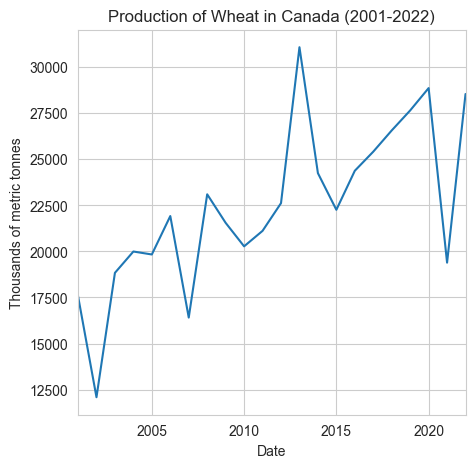

In [14]:
# looks like we have 22 observations...

# Now let's graph the time series
ser_wheat_production = pd.Series(data=production_df["VALUE"].values, index=production_df["REF_DATE"], name="production")

plt.figure(figsize=(5, 5))
# chicken count
plt.subplot(1, 1, 1)
labels = dict(
    xlabel="Date",
    ylabel="Thousands of metric tonnes",
    title=f"Production of Wheat in Canada ({ser_wheat_production.index.min().year}-{ser_wheat_production.index.max().year})"
)
ser_wheat_production.plot(**labels)


Now that we have a time series for prices and production, let's merge them into a single dataframe.


In [15]:
final_df = pd.DataFrame(data={"prices": ser_wheat_prices}).join(ser_wheat_production)
final_df['Eins'] = np.ones((len(final_df),))
final_df = final_df.dropna()
final_df

,prices,production,Eins
YEAR,,,



This is that problem identified above where the date indices do not match up...

We can use the `Series.resample` method to deal with this

In [16]:
# use resample method to get index to be the first of every month
ser_wheat_production = ser_wheat_production.resample("YS").first()
final_df = pd.DataFrame(data={"prices": ser_wheat_prices}).join(ser_wheat_production).dropna()
final_df['Eins'] = np.ones((len(final_df), ))
final_df


,prices,production,Eins
YEAR,,,
2001-01-01,172.838333,17580.7,1.0
2002-01-01,189.052500,12084.4,1.0
2003-01-01,186.859375,18837.0,1.0
2004-01-01,181.151875,19994.1,1.0
2005-01-01,136.585417,19833.5,1.0
2006-01-01,158.150208,21919.2,1.0
2007-01-01,205.249375,16409.0,1.0
2008-01-01,262.575833,23099.9,1.0
2009-01-01,217.153333,21550.3,1.0


Text(0.5, 28.999999999999986, 'Dollars per metric tonne')

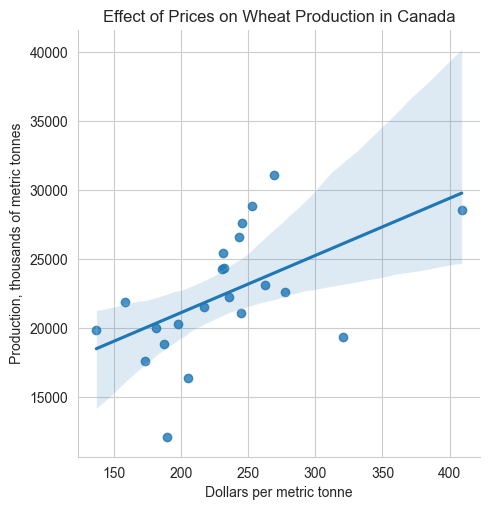

In [17]:
# let's use a linear regression to explore the relationship between prices and production

# a scatter plot and the OLS regression line plotted
sns.lmplot(data=final_df, x="prices", y="production")
plt.title("Effect of Prices on Wheat Production in Canada")
plt.ylabel("Production, thousands of metric tonnes")
plt.xlabel("Dollars per metric tonne")

In [18]:
# finally let's look at the results from the regression

Y = final_df["production"]
X = final_df[['prices', 'Eins']]
results = sm.OLS(Y, X).fit()
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     8.065
Date:                Mon, 11 Dec 2023   Prob (F-statistic):             0.0101
Time:                        12:50:22   Log-Likelihood:                -212.00
No. Observations:                  22   AIC:                             428.0
Df Residuals:                      20   BIC:                             430.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
prices        41.3883     14.574      2.840      0.0

### linear regression results:

the model's intercept was found to be `1.285e4` and the coefficient for the `prices` variable is `41.3883`

`Production  =  1.285e4 + 41.3883 x Price` 

The F-staticic for this model was `8.065` and the changes of observing this statistic under a normal distribution is less than 0.05 %. Therefore, with a p-value set to 0.05, we would reject the null hypothesis. 

The R<sup>2</sup> is `0.28` which means approximately 30% of the variance of the data can be accounted for by this model. There is more unexplained variability in these data compared to the chicken meat    



